In this datasheet we explore the question whether there is a tendency for teams in the NHL 
to loose a game after they had not one the last few days. Therefore we assemble the statistics
for wins and losses for every team and collect them in one probability plot.

In [2]:
DATACAPTIONVEC <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE")
MYTEAM="NYI"

In [3]:
#read summed and delta NHL data
#from datasets created using python
nhlDataSum=data.frame()
nhlDataDelta=data.frame()
SeasonVector=c(2010,2011,2012,2014,2015,2016)
NumberOfSeasons=length(SeasonVector)
for(season in SeasonVector)
{
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_sum.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataSum<-rbind(nhlDataSum,nhlDataS)
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_delta.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataDelta<-rbind(nhlDataDelta,nhlDataS)
}
colnames(nhlDataSum) <- DATACAPTIONVEC
colnames(nhlDataDelta) <- DATACAPTIONVEC

In [4]:
getTeamGameByGame <- function(teamname,inputData)
{
  teamMatchupsH<-subset(inputData,inputData$TEAM1==teamname)
  teamMatchupsA<-subset(inputData,inputData$TEAM2==teamname)
  #create a new data frame and pool the data there
  #teamMatchups<-data.frame(teamMatchupsH,teamMatchupsA)
  teamMatchups<-teamMatchupsH
  teamMatchups<-rbind(teamMatchups,teamMatchupsA)
  #now we sort first by date, then by season to restore the correct temporal ordering of events
  teamMatchups[order(teamMatchups$DATE,teamMatchups$SEASON),]
  #extract the data columns we need
  dateOfMatchups <- teamMatchups$DATE
  wonMatchup <- teamMatchups$WON
  #take differences of vector date values
  oldDate=0 #start at date zero
  timeBetweenMatchups=c()
  teamHasWonVector=c()

  #now store if the team has won or not - if team1 simply the WIN entry, if team2 1-WIN!
  #use a local function only
  getWins <- function(thisTeamName,team1,team2,hwon) 
  {
    if((team1==thisTeamName && hwon==1)||(team2==thisTeamName && hwon==0)) 
    {return(1)}
    else
    {return(0)}
  }
    
  teamHasWonVector <- mapply(getWins,teamname,teamMatchups$TEAM1,teamMatchups$TEAM2,teamMatchups$WON)

  for(currentDate in dateOfMatchups)
  {
    computedDateDifference=currentDate-oldDate
    if(computedDateDifference>50) #we are in new season - set to zero
    {
      computedDateDifference=0
    }
    timeBetweenMatchups <- rbind(timeBetweenMatchups,computedDateDifference)

    oldDate=currentDate
  }
  
  #check if vectors have the same length
  stopifnot(length(timeBetweenMatchups)==length(dateOfMatchups))
  #now attach data
  teamMatchups <- cbind(teamMatchups,timeBetweenMatchups,teamHasWonVector)
  #add a new caption for the last column
  colnames(teamMatchups) <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE","DAYS_SINCE_LAST_GAME","WON_FOR_DAYS_SINCE_LAST_GAME")
  
  return(teamMatchups)
}

In the next step we compute for every team separately the days off and if it has won by calling above function "getTeamGameByGame", which returns two additional columns for the data, which we can evaluate subsequently. First let's get the list of NHL teams.

In [5]:
#get list of teams
teams <- nhlDataDelta$TEAM1
LISTOFTEAMS=unique(teams)

In [6]:
#compute for every game the days off the team had before this game
teamGamebyGameDeltaFrameList <- c()
teamGamebyGameSumFrameList <- c()

for(team in LISTOFTEAMS)
{
 tmpData <- getTeamGameByGame(team,nhlDataDelta)
 teamGamebyGameDeltaFrameList <- rbind(teamGamebyGameDeltaFrameList,tmpData)
 tmpData <- getTeamGameByGame(team,nhlDataSum)
 teamGamebyGameSumFrameList <- rbind(teamGamebyGameSumFrameList,tmpData)
}
teamGamebyGameDeltaFrameList.names <- LISTOFTEAMS
teamGamebyGameSumFrameList.names <- LISTOFTEAMS

In [7]:
data=teamGamebyGameDeltaFrameList

gamesWonV=c()
gamesLostV=c()

#loop over days off

for(dayPauseBetweenGames in 1:15)
{
  getWonData <- data[which(data$DAYS_SINCE_LAST_GAME %in% dayPauseBetweenGames),]
  wonColumn=getWonData$WON_FOR_DAYS_SINCE_LAST_GAME
  numberOfGames=length(wonColumn)
  numberOfWins=length(which(wonColumn %in% 1))
  Pwin <- numberOfWins/numberOfGames
  Ploss <- (numberOfGames-numberOfWins)/numberOfGames
    #sumList <- colSums(getWonData[,colIsNumericVector==TRUE],na.rm=FALSE)
  gamesWonV <- rbind(gamesWonV,Pwin)
  gamesLostV <- rbind(gamesLostV,Ploss)
  #listWon  
}

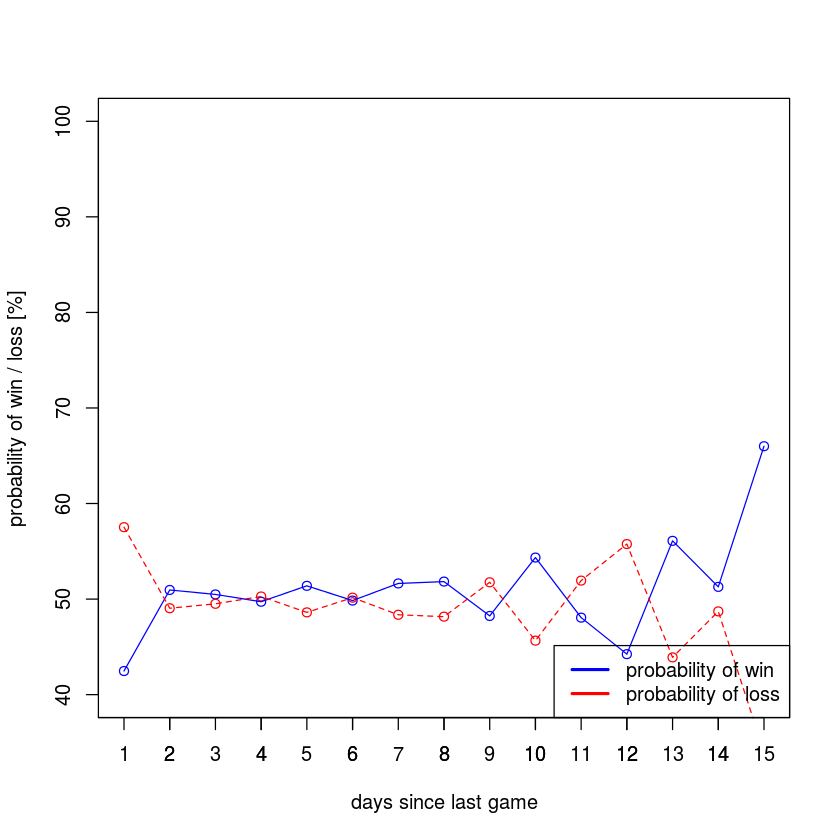

In [15]:
plot(gamesWonV*100,col="blue",xlab="days since last game",ylab="probability of win / loss [%]",ylim=c(40,100),xlim=c(1,15))
#par(new=TRUE)
points(gamesLostV*100,col="red",ylim=c(0,100))
lines(gamesWonV*100,lty = 1,col="blue")
lines(gamesLostV*100,lty = 2,col="red")
axis(side=1, at=c(0:length(gamesWonV)))
legend('bottomright', c("probability of win","probability of loss"),lty=c(1,1),lwd=c(2.5,2.5),col=c("blue","red"))
